In [1]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import pandas as pd
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 20)
        self.fc5 = nn.Linear(20, 18)

    def forward(self, x):
        # print("type x", type(x))
        # x = self.fc1(x)
        # x = F.relu(x)
        # x = self.fc2(x)
        # x = F.relu(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        x = self.fc5(x)
        return x

In [3]:
class CustomDataset(Dataset):
    def __init__(self, file_path):
        df = pd.read_csv(file_path)
        self.x = df.iloc[:,0].values
        self.y = df.iloc[:,1].values
        # self.a = df.iloc[:, 0].values
        # self.b = df.iloc[:, 1].values
        # self.c = df.iloc[:, 2].values
        # self.y = df.iloc[:, 3].values
        # self.y = list(map(self.string_to_vector, self.y))
        self.length = len(df)

    # def string_to_vector(self, value):
    #     data = {"acute triangle": 0, "right triangle":1, "obtuse triangle": 2}
    #     return data.get(value, None)

    def __getitem__(self, index):
        x = self.x[index]
        # x = list(str(x))[:-6]
        # x = list(map(int, x))
        # while(len(x)<8):
        #     x.insert(0, 0)
        x = list(x)[:-6]
        x = list(map(int, x))
        x = torch.FloatTensor(x)
        # x = torch.FloatTensor(sorted([self.a[index], self.b[index], self.c[index]]))
        y = torch.LongTensor(self.y)[index]
        # print(x, y)
        return x, y

    def __len__(self):
        return self.length

In [4]:
# train_dataset = CustomDataset("txt/data2.csv")
full_dataset = CustomDataset("txt/single_llc_set_false.csv")
# full_dataset = CustomDataset("/content/drive/MyDrive/학부/4학년 2학기/hash/txt/data.csv")
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=1)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Net().to(device)
print(model)

Net(
  (fc1): Linear(in_features=28, out_features=124, bias=True)
  (fc2): Linear(in_features=124, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=18, bias=True)
)


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
losses = []

# indices = torch.randperm(len(train_dataset))[:64768]
# sampler = SubsetRandomSampler(indices)
# train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False, drop_last=True, sampler=sampler)

for epoch in range(10000):
    cost = 0.0

    # indices = torch.randperm(len(train_dataset))[:129536]
    # sampler = SubsetRandomSampler(indices)
    # train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False, drop_last=True, sampler=sampler)

    # for i, batch in enumerate(tqdm(train_dataloader)):
    for x, y in train_dataloader:
        # x = batch[0].to(device)
        # y = batch[1].to(device)
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        
        output = model(x)

        loss = criterion(output, y)
        print(output, y)

        loss.backward()
        optimizer.step()

        cost += loss

        print(f"Epoch : {epoch+1:4d}, Loss : {loss:.3f}")

    cost = cost / len(train_dataloader)
    losses.append(cost)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch : {epoch+1:4d}, Cost : {cost:.3f}")

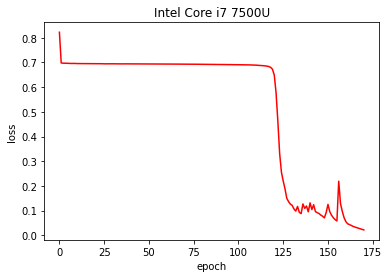

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:46<00:00, 2132.23it/s]

--------------
Accuracy:  99.449


In [7]:
losses_int = [ts.item() for ts in losses]
plt.plot(losses_int, 'r')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Intel Core i7 7500U')
plt.show()

indices = torch.randperm(len(test_dataset))[:100000]
sampler = SubsetRandomSampler(indices)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=True, sampler=sampler)

# GET OUTPUT
with torch.no_grad():
    model.eval()
    
    total = 0
    correct = 0

    for i, batch in enumerate(tqdm(test_dataloader)):
        x = batch[0].to(device)
        y = batch[1].to(device)
        # x = x.to(device)
        # y = y.to(device)
        output = model(x)
        y_pred = torch.argmax(output, dim=1).to(device)
        total += 1
        # print(x, y, y_pred)
        if (y == y_pred): 
            correct += 1

print('--------------')
print('Accuracy: ', correct / total * 100)